In [1]:
import cv2
import json
import numpy as np
import pandas as pd
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

SEED = 19

def seed_everything(seed):
    """
    Fixing random seed for all libraries.
    """

    import os

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [3]:
path2data = '/kaggle/input/airport-stand-vehicle-detection/Assaia_Junior ML test task'

with open(path2data + '/polygons.json') as file:
    polygons = json.load(file)

with open(path2data + '/time_intervals.json') as file:
    time_intervals = json.load(file)

### Отрисую пару случайных кадров

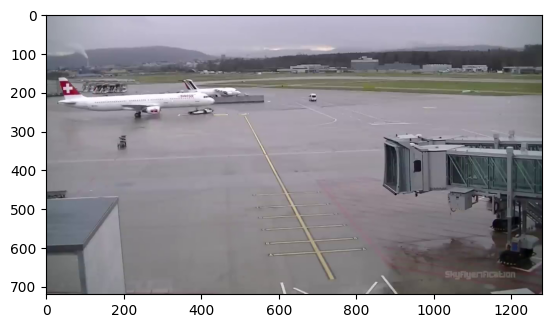

In [4]:
# https://medium.com/dida-machine-learning/how-to-recognise-objects-in-videos-with-pytorch-44f39f4c22f9

# Откроем первый кадр видео, чтобы посмотреть.
video_path = path2data + '/videos/video_2.mp4'
video = cv2.VideoCapture(video_path)

ret, frame = video.read()

video.release()

plt.imshow(frame[:,:,::-1]) # Перевод из BGR (OpenCV) в RGB (matplotlib)
plt.show()

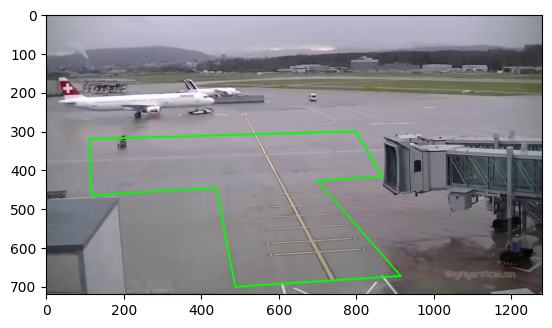

In [5]:
# Координаты bounding box
points = polygons['video_2.mp4']

# Преобразование координат в формат, подходящий для cv2.polylines
pts = np.array(points, np.int32)
pts = pts.reshape((-1, 1, 2))

# Отрисовка bounding box на кадре
cv2.polylines(frame, [pts], isClosed=True, color=(0, 255, 0), thickness=3)

plt.imshow(frame[:,:,::-1])  # Перевод из BGR в RGB
plt.show()

### Порисую разные кадры для разных видео и и посмотрю, попадает ли на данном кадре транспорт в полигон

video_2

Общее количество кадров 64

Кадр 56 не находится в интервалах [[40, 43], [57, 60]]
Транспорт не попал в полигон


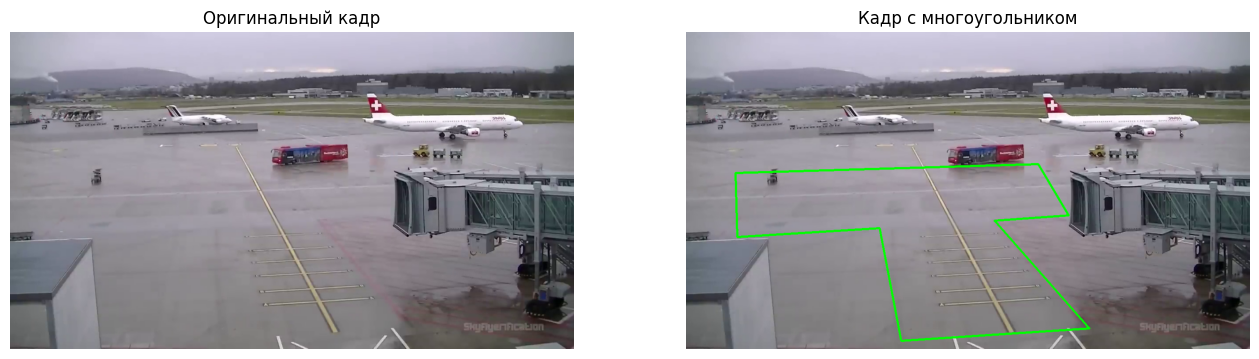

In [6]:
# Функция для подсчета кол-ва кадров в видео
def get_frame_count(video_path):
    video = cv2.VideoCapture(video_path)
    # Переменная для подсчета кадров
    frame_count = 0

    # Чтение каждого кадра
    while True:
        ret, frame = video.read()
        # Если кадр не был успешно считан (конец файла), выходим из цикла
        if not ret:
            break
        frame_count += 1

    video.release()
    
    return frame_count

# Функция, которая проверяет, находится ли заданный кадр в одном из временных интервалов
def is_frame_number_in_intervals(frame_number, intervals):
    for interval in intervals:
        if interval[0] <= frame_number <= interval[1]:
            return True
    return False

# Функция принимает путь к видео, номер кадра и возвращает кадр
def get_frame(video_path, frame_number):
    video = cv2.VideoCapture(video_path)
    # Перемещаемся к указанному кадру
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = video.read()
    video.release()
    return frame

# Функция для отрисовки многоугольника на кадре
def plot_polygon_on_frame(frame, polygon):
    pts = np.array(polygon, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(frame, [pts], isClosed=True, color=(0, 255, 0), thickness=3)

# Функция принимает путь к видео, номер кадра и координаты многоугольника
def draw_frame_with_polygon(video_number, frame_number):
    
    print(f'video_{video_number}')
    print()
    
    video_path = path2data + f'/videos/video_{video_number}.mp4'
    polygon = polygons[f'video_{video_number}.mp4']
    time_interval = time_intervals[f'video_{video_number}.mp4']
    
    # Посмотрим общее количество кадров
    frame_count = get_frame_count(video_path)   
    print(f'Общее количество кадров {frame_count}')
    print()
    
    # Сперва проверим, находится ли данный кадр в одном из интервалов
    result = is_frame_number_in_intervals(frame_number, time_interval)
    print(f"Кадр {frame_number} {'находится' if result else 'не находится'} в интервалах {time_interval}")
    print(f"Транспорт{'' if result else ' не'} попал в полигон")

    # Теперь отрисуем кадр с многоугольником и без
    frame = get_frame(video_path, frame_number)
    frame_copy = np.copy(frame)
    plot_polygon_on_frame(frame_copy, polygon)

    plt.figure(figsize=(16, 8))

    # Кадр без многоугольника
    plt.subplot(1, 2, 1)  
    plt.imshow(frame[:,:,::-1])  # Конвертируем из BGR в RGB
    plt.title('Оригинальный кадр')
    plt.axis('off')

    # Кадр с многоугольником
    plt.subplot(1, 2, 2) 
    plt.imshow(frame_copy[:,:,::-1])  # Конвертируем из BGR в RGB
    plt.title('Кадр с многоугольником')
    plt.axis('off')

    plt.show()

draw_frame_with_polygon(video_number=2, frame_number=56)

video_15

Общее количество кадров 38

Кадр 30 не находится в интервалах [[10, 29]]
Транспорт не попал в полигон


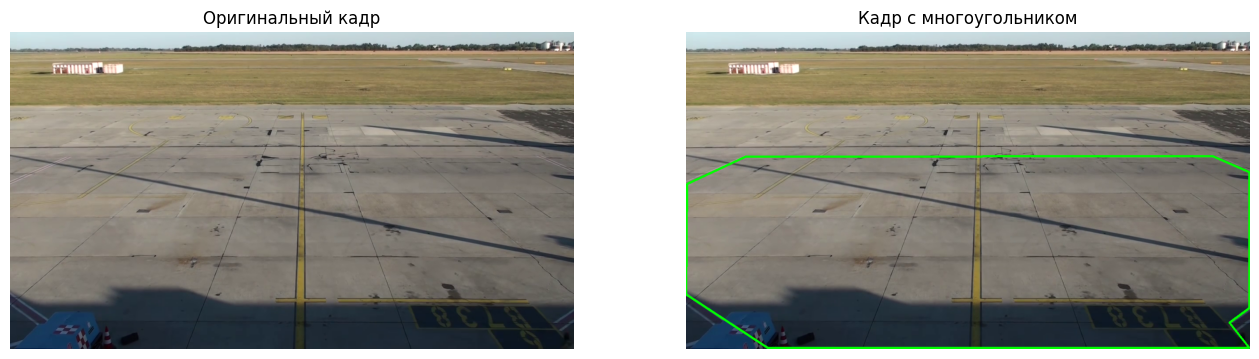

In [7]:
draw_frame_with_polygon(video_number=15, frame_number=30)

video_5

Общее количество кадров 145

Кадр 18 находится в интервалах [[14, 19], [34, 38], [73, 95]]
Транспорт попал в полигон


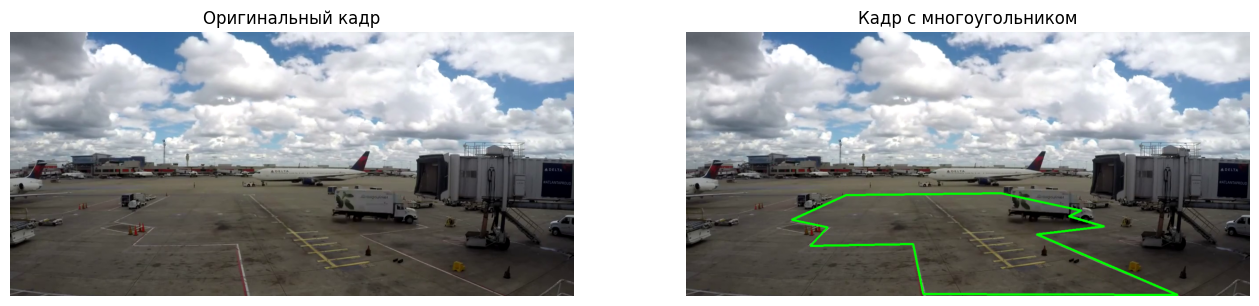

In [8]:
draw_frame_with_polygon(video_number=5, frame_number=18)

1. После того, как я отрисовала несколько случайных кадров внутри тайм-маркера и несколько кадров из-вне тайм-маркера, появилась идея, что для решения задачи обнаружения транпорта в полигоне можно поставить и решать задачу классификации:
    1. если внутри тайм-маркера авто -> кадр классифицируем 1, кадры вне тайм-маркера - 0
    2. вырезать полигон, западить белым цветом и классифицировать
    3. В случае дисбаланса классов -> взвешивание 
    

2. Также я приняла решение убрать из датасета видео 4, т к на нем в полигон практически не попадает транспорт (для time_intervals) - см ниже (видео зашумит выборку)

video_4

Общее количество кадров 73

Кадр 46 находится в интервалах [[19, 52]]
Транспорт попал в полигон


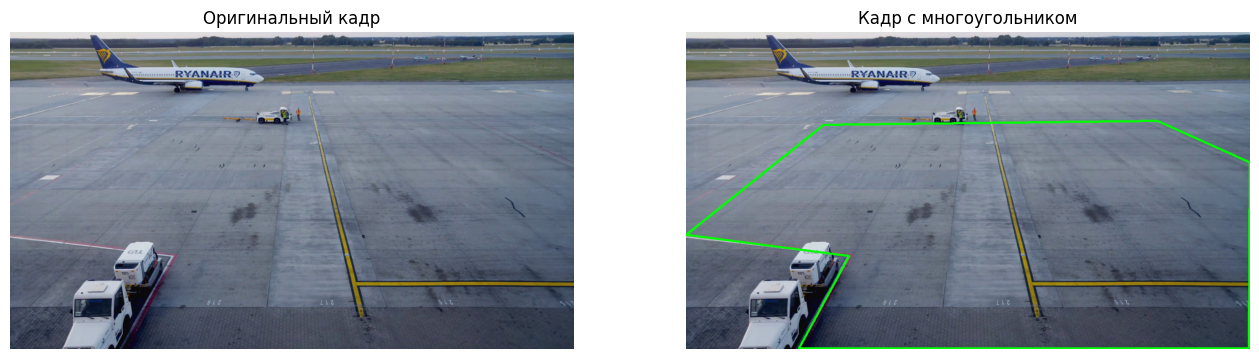

In [9]:
draw_frame_with_polygon(video_number=4, frame_number=46)

video_0

Общее количество кадров 39

Кадр 33 не находится в интервалах []
Транспорт не попал в полигон


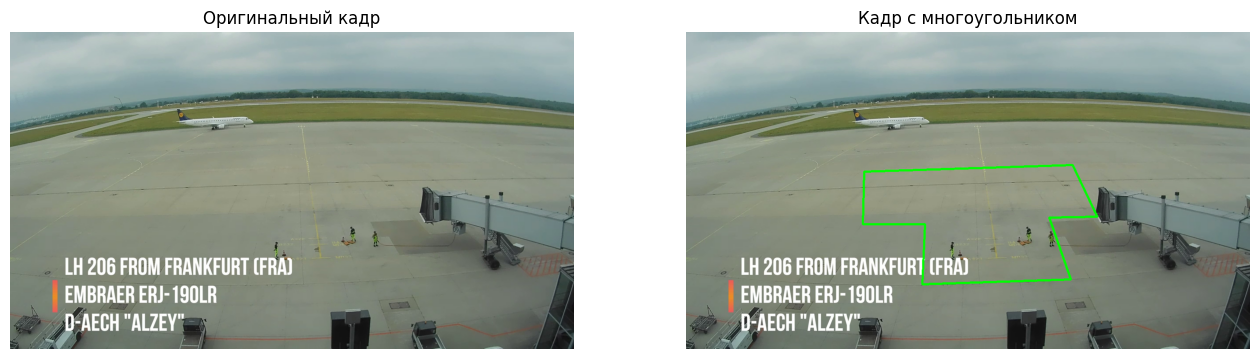

In [10]:
draw_frame_with_polygon(video_number=0, frame_number=33)

### Статистика по кадрам

In [11]:
def get_frame_per_sec(video_path):
    video = cv2.VideoCapture(video_path)  
    # Получаем частоту кадров в секунду (FPS)
    fps = video.get(cv2.CAP_PROP_FPS)  
    video.release() 
    return fps

def total_frames_in_intervals(intervals):
    total_frames = 0
    for interval in intervals:
        total_frames += interval[1] - interval[0] + 1
    return total_frames

In [12]:
frame_counts = 0
total_target_frames = 0
# видео 12 в выборке нет, видео 4 убираю
for video_number in [j for j in range(0, 20) if j not in [4, 12]]: 
    video_path = path2data + f'/videos/video_{video_number}.mp4'
    fps = get_frame_per_sec(video_path)
    frame_count = get_frame_count(video_path)
    frame_counts += frame_count
    
    time_interval = time_intervals[f'video_{video_number}.mp4']
    total_frames = total_frames_in_intervals(time_interval)
    total_target_frames += total_frames
    
    print(f'video_{video_number}.mp4')
    print(f'Кадров в секунду: {fps}')
    print(f'Общее количество кадров в видео: {frame_count}')
    print(f'time_interval для видео: {time_interval}')
    print(f'Общее количество кадров с транспортным средством в полигоне: {total_frames}')
    print(f'Общее количество кадров с транспортным средством вне полигона: {frame_count-total_frames}')
    print('-' * 20)
    print()
print(f'Всего кадров для всех видео: {frame_counts}')
print(f'Всего кадров с транспортным средством в полигоне для всех видео: {total_target_frames}')

video_0.mp4
Кадров в секунду: 30.0
Общее количество кадров в видео: 39
time_interval для видео: []
Общее количество кадров с транспортным средством в полигоне: 0
Общее количество кадров с транспортным средством вне полигона: 39
--------------------

video_1.mp4
Кадров в секунду: 2.0
Общее количество кадров в видео: 18
time_interval для видео: [[4, 12]]
Общее количество кадров с транспортным средством в полигоне: 9
Общее количество кадров с транспортным средством вне полигона: 9
--------------------

video_2.mp4
Кадров в секунду: 10.0
Общее количество кадров в видео: 64
time_interval для видео: [[40, 43], [57, 60]]
Общее количество кадров с транспортным средством в полигоне: 8
Общее количество кадров с транспортным средством вне полигона: 56
--------------------

video_3.mp4
Кадров в секунду: 30.0
Общее количество кадров в видео: 55
time_interval для видео: [[43, 50]]
Общее количество кадров с транспортным средством в полигоне: 8
Общее количество кадров с транспортным средством вне поли

In [13]:
print(1391-596)

795


### промежуточный вывод: 
1. Всего кадров 1391 - неплохо для бин классификации
2. Выборка довольно сбалансирована по кадрам: 
- 596 кадров с транспортным средством внутри полигона 
- 795 кадров без транспортного средства внутри полигона
3. Можно еще добавить аугментаций (нужно думать, каких, данные специфические)

### Буду вырезать полигоны из изображений - собирать данные для обучения

Размер нового фрейма: (237, 835, 3)


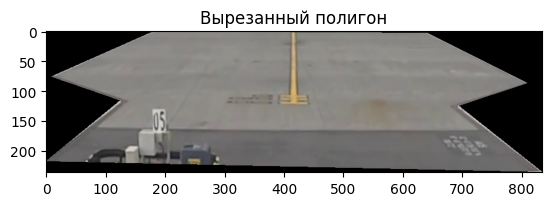

In [14]:
# Функция принимает кадр и координаты многоугольника и возвращает вырезанный полигон
def extract_polygon_frame(frame, polygon):
    # Создаем маску с теми же размерами, что и кадр
    mask = np.zeros_like(frame)

    # Заполняем маску
    cv2.fillPoly(mask, [np.array(polygon, np.int32)], (255, 255, 255))

    # Применяем маску к кадру
    masked_frame = cv2.bitwise_and(frame, mask)

    # Находим ограничивающий прямоугольник для полигона
    x, y, w, h = cv2.boundingRect(np.array(polygon, np.int32))

    # Вырезаем полигон из кадра
    cropped_frame = masked_frame[y:y+h, x:x+w]

    return cropped_frame

# Кадр и полигон
video_number = 19
video_path = path2data + f'/videos/video_{video_number}.mp4'
frame_number = 21
frame = get_frame(video_path, frame_number)
polygon = polygons[f'video_{video_number}.mp4']

# Извлекаем полигон из кадра
cropped_frame = extract_polygon_frame(frame, polygon)
print(f'Размер нового фрейма: {cropped_frame.shape}')

# Отображаем вырезанный полигон
plt.imshow(cropped_frame[:,:,::-1])  # Перевод из BGR в RGB
plt.title("Вырезанный полигон")
plt.show()

In [15]:
data = {}
for video_name, polygon in polygons.items():
    cropped_frames = []
    
    video_path = path2data + f'/videos/{video_name}'
    video = cv2.VideoCapture(video_path)
    while True:
        ret, frame = video.read()  # Считывание очередного кадра
        # Проверяем, был ли кадр успешно считан
        if not ret:
            break  # Прерываем цикл, если кадры закончились
            
        cropped_frame = extract_polygon_frame(frame, polygon)
        cropped_frames.append(cropped_frame)
    data[video_name] = cropped_frames

In [16]:
data.keys()

dict_keys(['video_0.mp4', 'video_1.mp4', 'video_2.mp4', 'video_3.mp4', 'video_4.mp4', 'video_5.mp4', 'video_6.mp4', 'video_7.mp4', 'video_8.mp4', 'video_9.mp4', 'video_10.mp4', 'video_11.mp4', 'video_13.mp4', 'video_14.mp4', 'video_15.mp4', 'video_16.mp4', 'video_17.mp4', 'video_18.mp4', 'video_19.mp4'])

### Соберу таргеты для бинарной классификации

In [17]:
def get_frame_labels(video_path, intervals):
    frame_count = get_frame_count(video_path)

    # Инициализация массива меток нулями
    labels = [0] * frame_count

    # Установка метки 1 для кадров в интервалах
    for interval in intervals:
        for i in range(interval[0], interval[1] + 1):
            labels[i] = 1

    return labels

frame_labels = {}
for video_name, intervals in time_intervals.items():
    video_path = path2data + f'/videos/{video_name}'
    labels = get_frame_labels(video_path, intervals)
    frame_labels[video_name] = labels

In [18]:
frame_labels.keys()

dict_keys(['video_0.mp4', 'video_1.mp4', 'video_2.mp4', 'video_3.mp4', 'video_4.mp4', 'video_5.mp4', 'video_6.mp4', 'video_7.mp4', 'video_8.mp4', 'video_9.mp4', 'video_10.mp4', 'video_11.mp4', 'video_13.mp4', 'video_14.mp4', 'video_15.mp4', 'video_16.mp4', 'video_17.mp4', 'video_18.mp4', 'video_19.mp4'])

### Dataset

In [19]:
class CustomDataset(Dataset):
    def __init__(self, data, frame_labels, transform=None):
        self.data = data
        self.frame_labels = frame_labels
        self.transform = transform

        # Формирование списка всех кадров и соответствующих меток
        self.frames = []
        self.labels = []
        for video_name, frames in self.data.items():
            self.frames.extend(frames)
            self.labels.extend(self.frame_labels[video_name])

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        label = self.labels[idx]

        # Преобразование кадра в формат, подходящий для PyTorch
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if self.transform:
            frame = self.transform(frame)

        return {'image': frame, 'label': label}

(516, 1280, 3) 1


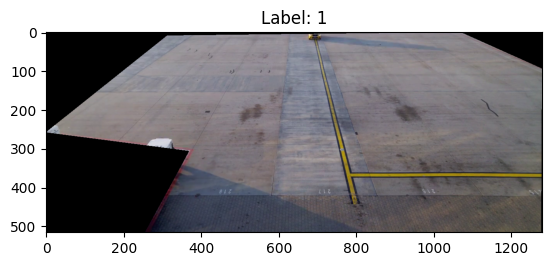

In [20]:
transform = None  
dataset = CustomDataset(data, frame_labels, transform=transform)

sample = dataset[164]
print(sample['image'].shape, sample['label'])
image, label = sample['image'], sample['label']

plt.imshow(image)
plt.title(f"Label: {label}")
plt.show()

In [21]:
IMAGE_WIDTH = 240 # стандартный размер входного изображения для EfficientNet-B1 составляет 240x240 пикселей
IMAGE_HIGHT = 480

normalize=torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#transformations
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                       transforms.Resize((IMAGE_WIDTH, IMAGE_HIGHT)),
                                       transforms.ToTensor(),                                
                                       normalize
                                       ])
                                       
test_transforms = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((IMAGE_WIDTH, IMAGE_HIGHT)),
                                      transforms.ToTensor(),
                                      normalize
                                      ])

### Соберу train и test датасеты

**Есть две стратегии разделения на тест/трейн:**
- по видео: 80%/20% видеофайлов на трейн/тест
- по кадрам: сначала все кадры замешать в один список, потом делить 80%/20% кадров на трейн/тест

Будем делить по видео, потому что это имитирует ситуацию, когда модели поступают новые видео

На глаз подберу номера видео для трейна и номера видео для теста: хочу, чтобы был баланс по 1/0 в тесте и трейне примерно одинаковым

Еще убрала видео 0 - оно зашулмяло выборку (при обуении модели ниже, если видео 0 было в трейне - метрика на тесте всегда была ниже)

In [22]:
train_frames = {}
test_frames = {}

# Перебираем ключи и разделяем данные на тренировочный и тестовый наборы
for i, (video_name, frames) in enumerate(data.items()):
    if i in [1, 3, 8, 17]:  
        test_frames[video_name] = frames
    elif i not in [0, 1, 3, 8, 17, 4]:  
        train_frames[video_name] = frames

In [23]:
train_labels = {}
test_labels = {}

# Перебираем ключи и разделяем метки на тренировочный и тестовый наборы
video_names = list(frame_labels.keys())
for i, video_name in enumerate(video_names):
    if i in [1, 3, 8, 17]:  
        test_labels[video_name] = frame_labels[video_name]
    elif i not in [0, 1, 3, 8, 17, 4]:  
        train_labels[video_name] = frame_labels[video_name]

In [24]:
train_dataset = CustomDataset(train_frames, 
                              train_labels, 
                              train_transforms
                             )
test_dataset = CustomDataset(test_frames, 
                             test_labels, 
                             test_transforms
                            )

In [25]:
train_y_true = []
for i in range(len(train_dataset)):
    train_y_true.append(train_dataset[i]['label'])
    
test_y_true = []
for i in range(len(test_dataset)):
    test_y_true.append(test_dataset[i]['label'])

In [26]:
print(pd.Series(train_y_true).value_counts()[1] / pd.Series(train_y_true).value_counts()[0])
print(pd.Series(train_y_true).value_counts())

0.7708006279434851
0    637
1    491
Name: count, dtype: int64


In [27]:
print(pd.Series(test_y_true).value_counts()[1] / pd.Series(test_y_true).value_counts()[0])
print(pd.Series(test_y_true).value_counts())

0.8823529411764706
0    119
1    105
Name: count, dtype: int64


image shape: torch.Size([3, 240, 480]), actual label: 0


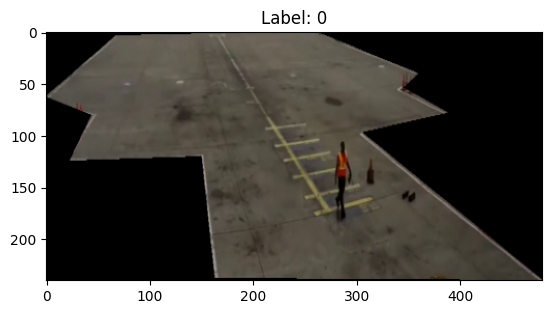

In [28]:
sample = train_dataset[164]
print(f"image shape: {sample['image'].shape}, actual label: {sample['label']}")
image, label = sample['image'], sample['label']

# Переставляем каналы цвета: из PyTorch (C, H, W) в Matplotlib (H, W, C)
image = image.permute(1, 2, 0).numpy()

# Денормализация изображения для корректного отображения
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean
image = np.clip(image, 0, 1)

plt.imshow(image)
plt.title(f"Label: {label}")
plt.show()

image shape: torch.Size([3, 240, 480]), actual label: 1


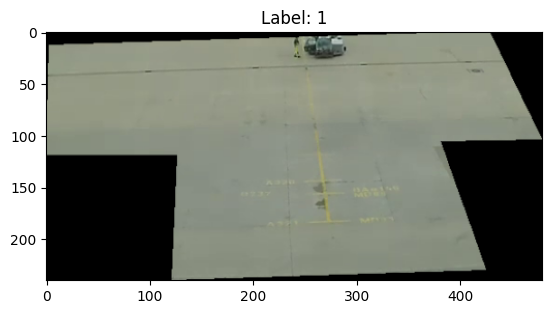

In [29]:
sample = test_dataset[5]
print(f"image shape: {sample['image'].shape}, actual label: {sample['label']}")
image, label = sample['image'], sample['label']

# Переставляем каналы цвета: из PyTorch (C, H, W) в Matplotlib (H, W, C)
image = image.permute(1, 2, 0).numpy()

# Денормализация изображения для корректного отображения
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean
image = np.clip(image, 0, 1)

plt.imshow(image)
plt.title(f"Label: {label}")
plt.show()


### Model side

In [30]:
BATCH_SIZE = 16

trainloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
 
testloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

### Можно выбрать более сложную модель, но может не хватить данных для дообучения

In [63]:
from torchvision import datasets, models, transforms
import torch.nn as nn

# Загрузка предобученной модели EfficientNet-B1
model = models.efficientnet_b1(pretrained=True)

# Изменение последнего полносвязного слоя для бинарной классификации
num_ftrs = model.classifier[1].in_features  # Получение количества входных признаков для классификатора
model.classifier[1] = nn.Linear(num_ftrs, 1)  # Замена на новый слой с одним выходом

# Перенос модели на устройство (если используется CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

criterion = BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

почему я выбрала f1_score: она комбинирует precision и recall, и в зависимости от запроса можно двигать баланс в одну или другую сторону

In [65]:
import copy

best_val_f1 = float('-inf') 
best_model_wts = copy.deepcopy(model.state_dict())

n_epochs=15
for epoch in range(n_epochs):
    model.train()  # Переключаем модель в режим обучения
    epoch_loss = 0
    all_labels = []
    all_predictions = []

    for data in tqdm(trainloader):
        x_batch, y_batch = data['image'], data['label']
        x_batch = x_batch.to(device)
        y_batch = y_batch.unsqueeze(1).float()
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predicted = torch.sigmoid(outputs).data > 0.5  # Пороговое значение для классификации
        all_labels.extend(y_batch.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
    
    scheduler.step()
    train_f1 = f1_score(all_labels, all_predictions)
    print(f'Epoch: {epoch}, Train Loss: {epoch_loss / len(trainloader)}, Train F1: {train_f1}')

    # Валидация
    model.eval()  # Переключаем модель в режим валидации
    val_loss = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in testloader:
            x_batch, y_batch = data['image'], data['label']
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float()
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            val_loss += criterion(outputs, y_batch).item()
            predicted = torch.sigmoid(outputs).data > 0.5
            all_labels.extend(y_batch.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_f1 = f1_score(all_labels, all_predictions)
    print(f'Epoch: {epoch}, Val Loss: {val_loss / len(testloader)}, Val F1: {val_f1}')
    
    # Проверка и сохранение наилучшей модели на основе F1-score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model_f1.pth')

# Загрузка лучших весов модели после завершения тренировки
model.load_state_dict(best_model_wts)

100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Epoch: 0, Train Loss: 0.36429321535036596, Train F1: 0.8102108768035516
Epoch: 0, Val Loss: 1.3918961712292262, Val F1: 0.7076923076923076


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Epoch: 1, Train Loss: 0.128079995014508, Train F1: 0.9588477366255144
Epoch: 1, Val Loss: 1.7550165397780282, Val F1: 0.6285714285714286


100%|██████████| 71/71 [00:19<00:00,  3.65it/s]


Epoch: 2, Train Loss: 0.08229746215675078, Train F1: 0.9744114636642783
Epoch: 2, Val Loss: 1.2788411847182684, Val F1: 0.7224334600760456


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Epoch: 3, Train Loss: 0.04530851649199153, Train F1: 0.9847094801223242
Epoch: 3, Val Loss: 1.6962343284061976, Val F1: 0.6875


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Epoch: 4, Train Loss: 0.031706720993945926, Train F1: 0.9938775510204082
Epoch: 4, Val Loss: 1.4341267815658025, Val F1: 0.7320754716981133


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Epoch: 5, Train Loss: 0.032718230553732165, Train F1: 0.9918200408997956
Epoch: 5, Val Loss: 1.6277680397033691, Val F1: 0.6926070038910507


100%|██████████| 71/71 [00:19<00:00,  3.68it/s]


Epoch: 6, Train Loss: 0.025630818988183434, Train F1: 0.9918367346938775
Epoch: 6, Val Loss: 1.54514023235866, Val F1: 0.6926070038910507


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Epoch: 7, Train Loss: 0.01928343174283878, Train F1: 0.9948927477017364
Epoch: 7, Val Loss: 1.8824627697467804, Val F1: 0.7415730337078652


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Epoch: 8, Train Loss: 0.016437438023145456, Train F1: 0.9959100204498978
Epoch: 8, Val Loss: 1.4897534336362566, Val F1: 0.7320754716981133


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Epoch: 9, Train Loss: 0.011753013773991818, Train F1: 0.9979591836734694
Epoch: 9, Val Loss: 1.6623665115662984, Val F1: 0.7320754716981133


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Epoch: 10, Train Loss: 0.012768935184256817, Train F1: 0.9969356486210419
Epoch: 10, Val Loss: 1.9100973435810633, Val F1: 0.7320754716981133


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Epoch: 11, Train Loss: 0.014875076152056351, Train F1: 0.9969356486210419
Epoch: 11, Val Loss: 1.660154334136418, Val F1: 0.6823529411764706


100%|██████████| 71/71 [00:19<00:00,  3.62it/s]


Epoch: 12, Train Loss: 0.009521047202673492, Train F1: 0.9979633401221996
Epoch: 12, Val Loss: 1.7289629110268183, Val F1: 0.7320754716981133


100%|██████████| 71/71 [00:19<00:00,  3.65it/s]


Epoch: 13, Train Loss: 0.013888547706916193, Train F1: 0.9948927477017364
Epoch: 13, Val Loss: 1.811322101524898, Val F1: 0.7272727272727272


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Epoch: 14, Train Loss: 0.01818704654620042, Train F1: 0.9959266802443992
Epoch: 14, Val Loss: 1.9272018926484245, Val F1: 0.7320754716981133


<All keys matched successfully>

### Инференс

In [66]:
def inference(test_data, image_idx, model, device):
    model.eval()  # Переключаем модель в режим валидации

    # Выбор образца из тестовых данных
    sample = test_data[image_idx]
    image, label = sample['image'], sample['label']

    # Подготовка изображения и предсказание
    image_tensor = image.unsqueeze(0).to(device)  # Добавляем размерность батча и отправляем на устройство
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.sigmoid(output) > 0.5

    # Отображение предсказания
    prediction_label = 'there is vehicle' if prediction.item() else 'no vehicle'
    print(f"Prediction: {prediction_label}")

    # Подготовка и отображение изображения
    image = image.permute(1, 2, 0).numpy()  # Перевод из формата CHW в HWC для matplotlib
        
    # Денормализация изображения для корректного отображения
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.title(f"True Label: {'there is vehicle' if label else 'no vehicle'}")
    plt.show()

Prediction: there is vehicle


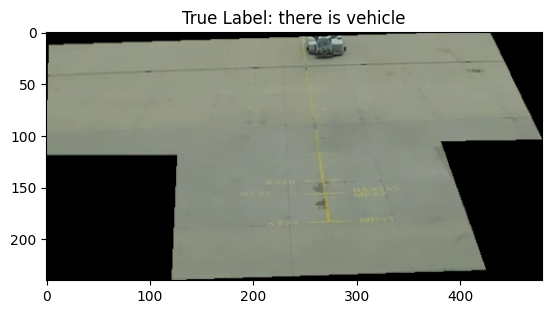

In [67]:
idx = 8
# idx = torch.randint(0, len(test_dataset), (1,)).item()
inference(test_data=test_dataset, image_idx=idx, model=model, device=device)

### Метрика

In [68]:
def get_predictions(test_data, image_idx, model, device):
    model.eval()  
    sample = test_data[image_idx]
    image, label = sample['image'], sample['label']

    image_tensor = image.unsqueeze(0).to(device)  # Добавляем размерность батча и отправляем на устройство
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.sigmoid(output) > 0.5
        
    return int(prediction.item())

In [69]:
preds = []
for i in range(len(test_dataset)):
    preds.append(get_predictions(test_dataset, i, model, device))

In [70]:
f1_score(test_y_true, preds)

0.7415730337078652

### Очень сильно качество зависит от разделения -> данные очень разнообразные -> для качественного решения имеет смысл сделать кросс-валидацию и иметь комбинацию нескольких моделей, чтобы получить более робастное решение